# **Demo: Construct a Forecasting Model and Evaluate Its Performance**

## **Step 1: Setup Python Packages**

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## **Step 2: Extract Data from SQL Server**

In [2]:
# Connection string components
server = 'DESKTOP'                  # Server name
database = 'Transactions'           # Database name
driver= 'SQL Server'                   

# SQLAlchemy connection string
connection_string = f'mssql+pyodbc://{server}/{database}?driver={driver}&trusted_connection=yes'

# Create the engine
engine = create_engine(connection_string)

query = '''
SELECT transaction_id, customer_id, 
       CAST(date AS DATE) as date, 
       CAST(time AS TIME) as time, 
       product_name, category, quantity, price
FROM dbo.Transactions
'''

# Use the engine to connect and execute the query
df = pd.read_sql_query(query, engine)

# Convert date and time into a single datetime column
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

# Set datetime as the index
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

# Prepare features and target variable
X = df.drop(['transaction_id', 'price', 'date', 'time'], axis=1)
y = df['price']

## **Step 3: Feature Engineering**

In [3]:
# Encoding categorical variables and scaling numerical variables
categorical_features = ['customer_id', 'product_name', 'category']
numerical_features = ['quantity']  # Adjust based on your data's features

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ])

## **Step 4:** **Initialize Model**

In [4]:
model = RandomForestRegressor(n_estimators=100, random_state=44)

## **Step 5:** **Pipeline Creation**

In [5]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)])

## **Step 6:** **Cross-validation**

In [6]:
# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Cross-validation across the time series data
cv_scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='neg_mean_squared_error')
print("Cross-validated scores:", np.sqrt(-cv_scores))
print("Mean RMSE:", np.sqrt(-cv_scores).mean())

Cross-validated scores: [33.77920718  5.21813307  0.12242345  1.91868774  0.6325    ]
Mean RMSE: 8.334190287847516


## **Step 7:** **Splitting Data**

In [7]:
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

## **Step 8:** **Train Model**

In [8]:
# Fit the model on the training set
pipeline.fit(X_train, y_train)

# Predict on the testing set
predictions = pipeline.predict(X_test)

## **Step 9:** **Evaluation**

In [9]:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Test MSE: {mse}")
print(f"Test R^2: {r2}")

Test MSE: 0.25537999999999994
Test R^2: 0.9999954778740594


## **Step 10:** **Plotting Actual vs Predicted Prices**

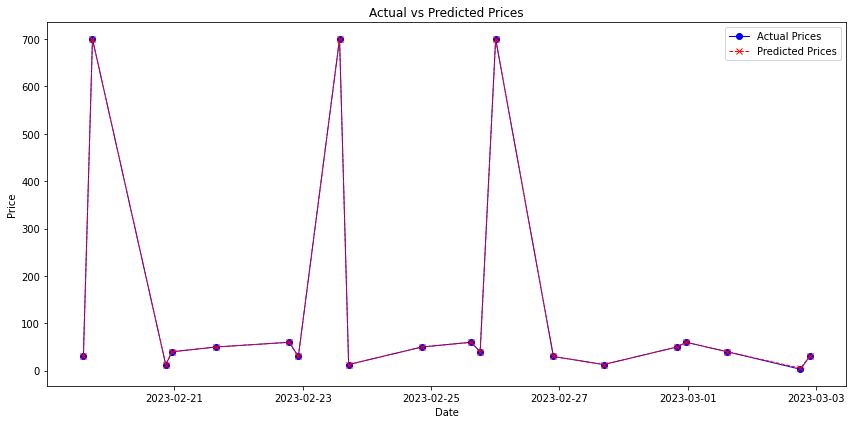

In [10]:
# Plotting actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue', marker='o', linestyle='-', linewidth=1)
plt.plot(y_test.index, predictions, label='Predicted Prices', color='red', marker='x', linestyle='--', linewidth=1)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()